# Sparse SPoSE Reconstruction Analysis - Results Visualization

This notebook creates comprehensive visualizations for the multi-seed comparison between ADMM and SPoSE models.


In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load all data files
DIMS = 49

results_df = pd.read_csv(f"../results/spose/{DIMS}/sparse_spose_recon.csv")
summary_df = pd.read_csv(f"../results/spose/{DIMS}/sparse_spose_recon_summary.csv")
similarity_df = pd.read_csv(f"../results/spose/{DIMS}/similarity_comparison.csv")
low_data_df = pd.read_csv(f"../results/spose/{DIMS}/sparse_spose_recon_low_data.csv")
spose_recon_df = pd.read_csv("../results/benchmarks/spose_reconstruction.csv")
spose_dimension_df = pd.read_csv("../results/spose/dimension_estimation/cv_results_trainset.csv")

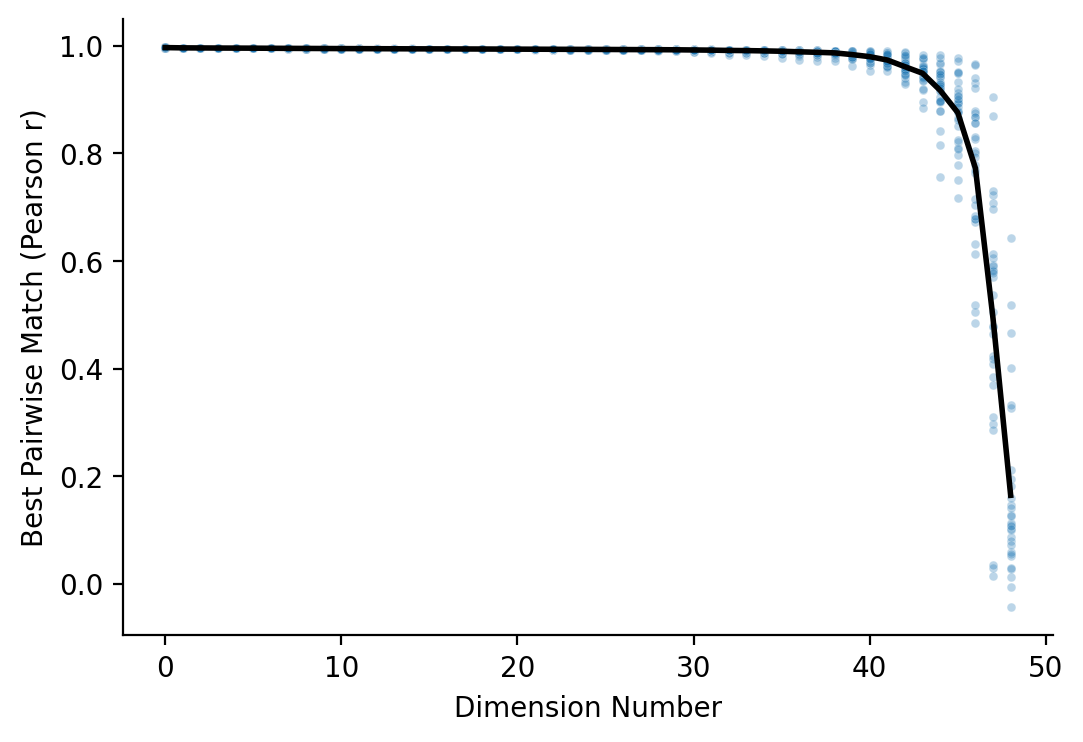

In [19]:
spose_recon_df = pd.read_csv("../results/benchmarks/spose_reconstruction.csv")

# Calculate mean correlation for each dimension
mean_corr = spose_recon_df.groupby("Dimension")["Correlation"].mean().reset_index()

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

# Plot individual points
sns.scatterplot(
    data=spose_recon_df, x="Dimension", y="Correlation", alpha=0.3, s=10, ax=ax
)

# Plot mean line
sns.lineplot(
    data=mean_corr, x="Dimension", y="Correlation", color="black", linewidth=2, ax=ax
)

ax.set_xlabel("Dimension Number")
ax.set_ylabel("Best Pairwise Match (Pearson r)")

sns.despine()


plt.show()

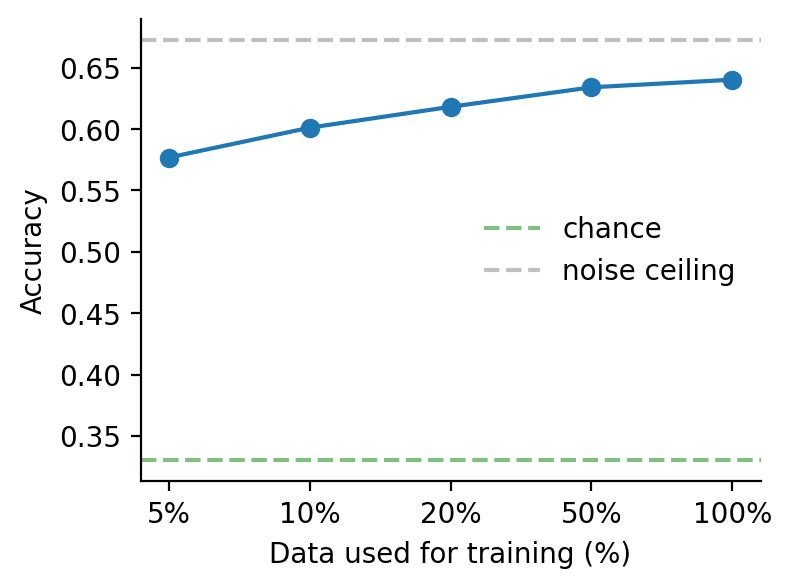

In [14]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

# Group by Data_Percentage and calculate mean and std
grouped = (
    low_data_df.groupby("Data_Percentage")["Accuracy"]
    .agg(["mean", "std"])
    .reset_index()
)

# Create evenly spaced x positions
x_positions = np.linspace(0, 1, len(grouped))

# Plot mean line with error bars
ax.errorbar(
    x_positions,
    grouped["mean"],
    yerr=grouped["std"],
    marker="o",
)


ax.set_ylabel("Accuracy")
ax.set_xlabel("Data used for training (%)")
ax.axhline(y=0.33, color="green", linestyle="--", alpha=0.5, label="chance")
ax.axhline(y=0.6722, color="gray", linestyle="--", alpha=0.5, label="noise ceiling")

# Set x-axis ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels([f"{p*100:.0f}%" for p in grouped["Data_Percentage"]])

ax.legend(frameon=False)
sns.despine()

plt.show()

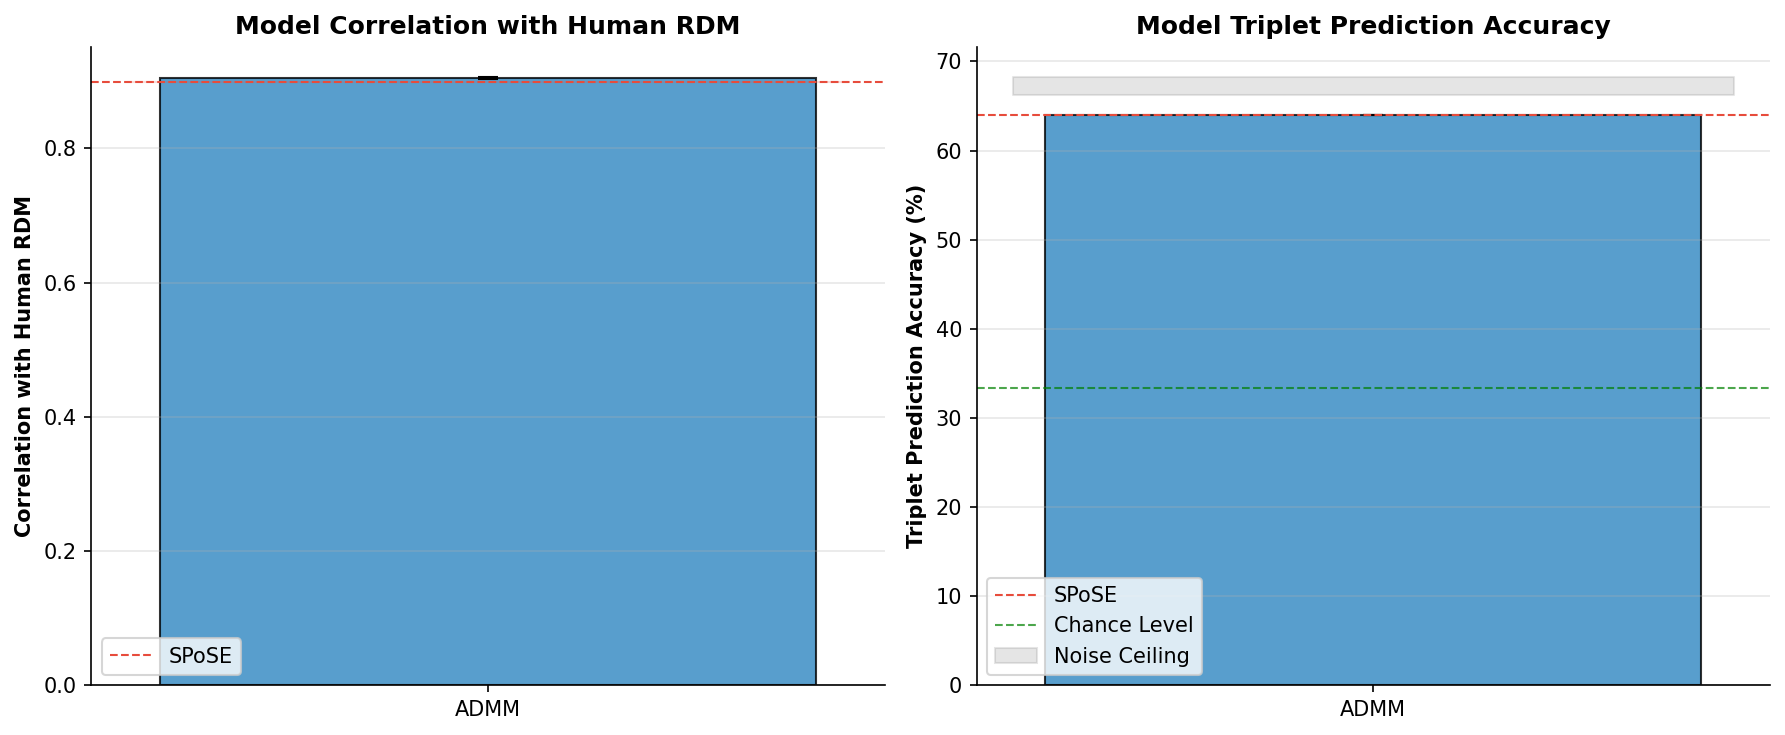

In [15]:
# Create subplots for correlation and accuracy side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Get data
corr_summary = summary_df[summary_df["Metric"] == "Correlation"]
acc_summary = summary_df[summary_df["Metric"] == "Accuracy"].copy()
acc_summary["Mean"] = acc_summary["Mean"] * 100
acc_summary["Std"] = acc_summary["Std"] * 100

# Get ADMM and SPoSE data
admm_corr = corr_summary[corr_summary["Model"] == "ADMM"]
spose_corr = corr_summary[corr_summary["Model"] == "SPoSE"]
admm_acc = acc_summary[acc_summary["Model"] == "ADMM"]
spose_acc = acc_summary[acc_summary["Model"] == "SPoSE"]

# Correlation plot
ax1.bar(
    ["ADMM"],
    admm_corr["Mean"].values,
    yerr=admm_corr["Std"].values,
    capsize=5,
    alpha=0.8,
    color="#2E86C1",
    edgecolor="black",
    linewidth=1,
)
ax1.axhline(
    y=spose_corr["Mean"].values[0],
    color="#E74C3C",
    linestyle="--",
    linewidth=1,
    label="SPoSE",
)
ax1.fill_between(
    ax1.get_xlim(),
    spose_corr["Mean"].values[0] - spose_corr["Std"].values[0],
    spose_corr["Mean"].values[0] + spose_corr["Std"].values[0],
    alpha=0.2,
    color="#E74C3C",
)
ax1.set_ylabel("Correlation with Human RDM", fontweight="bold")
ax1.set_title("Model Correlation with Human RDM", fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Accuracy plot
ax2.bar(
    ["ADMM"],
    admm_acc["Mean"].values,
    yerr=admm_acc["Std"].values,
    capsize=5,
    alpha=0.8,
    color="#2E86C1",
    edgecolor="black",
    linewidth=1,
)
ax2.axhline(
    y=spose_acc["Mean"].values[0],
    color="#E74C3C",
    linestyle="--",
    linewidth=1,
    label="SPoSE",
)
ax2.axhline(
    y=33.33, color="green", linestyle="--", linewidth=1, alpha=0.7, label="Chance Level"
)

# Add noise ceiling as shaded region
noise_ceiling_mean = 67.22
noise_ceiling_std = 1.04
ax2.fill_between(
    ax2.get_xlim(),
    noise_ceiling_mean - noise_ceiling_std,
    noise_ceiling_mean + noise_ceiling_std,
    alpha=0.2,
    color="gray",
    label="Noise Ceiling",
)

ax2.set_ylabel("Triplet Prediction Accuracy (%)", fontweight="bold")
ax2.set_title("Model Triplet Prediction Accuracy", fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3, axis="y")

sns.despine()
plt.tight_layout()
plt.show()

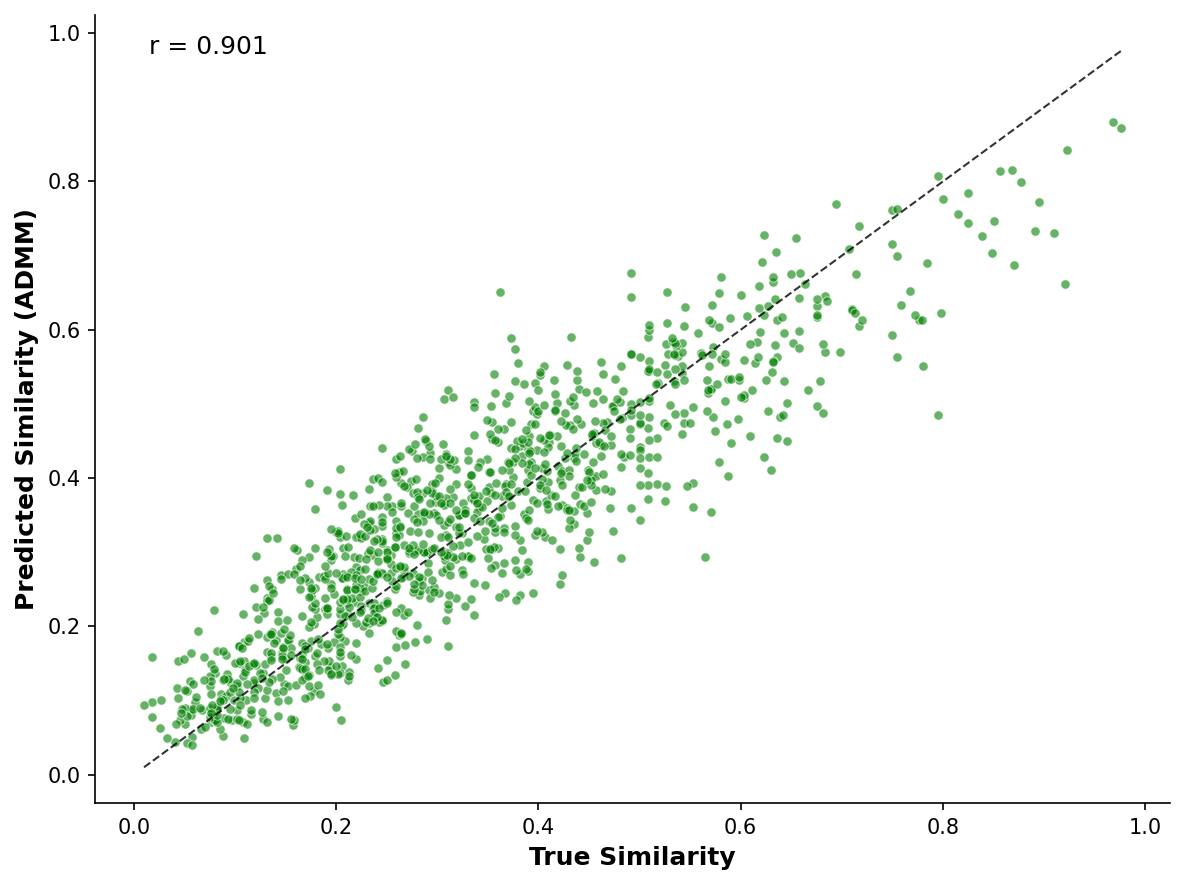

In [18]:
# Filter data for ADMM model only and seed 0
admm_data = similarity_df[
    (similarity_df["model"] == "ADMM") & (similarity_df["seed"] == 0)
]

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Scatter plot with true similarity on x-axis and predicted similarity on y-axis
scatter = ax.scatter(
    admm_data["true_similarity"],
    admm_data["predicted_similarity"],
    alpha=0.6,
    color="green",  # Changed to green
    s=20,
    edgecolors="white",
    linewidth=0.5,
)

# Add perfect correlation line
min_val = min(
    admm_data["true_similarity"].min(), admm_data["predicted_similarity"].min()
)
max_val = max(
    admm_data["true_similarity"].max(), admm_data["predicted_similarity"].max()
)
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    "k--",  # Changed to black dashed line
    alpha=0.8,
    linewidth=1,
)

# Calculate and add correlation coefficient
correlation = np.corrcoef(
    admm_data["true_similarity"], admm_data["predicted_similarity"]
)[0, 1]
ax.text(
    0.05,
    0.95,
    f"r = {correlation:.3f}",
    transform=ax.transAxes,
    fontsize=12,
)

# Customize plot
ax.set_xlabel("True Similarity", fontweight="bold", fontsize=12)
ax.set_ylabel("Predicted Similarity (ADMM)", fontweight="bold", fontsize=12)
# Remove spines
sns.despine()

plt.tight_layout()
plt.show()

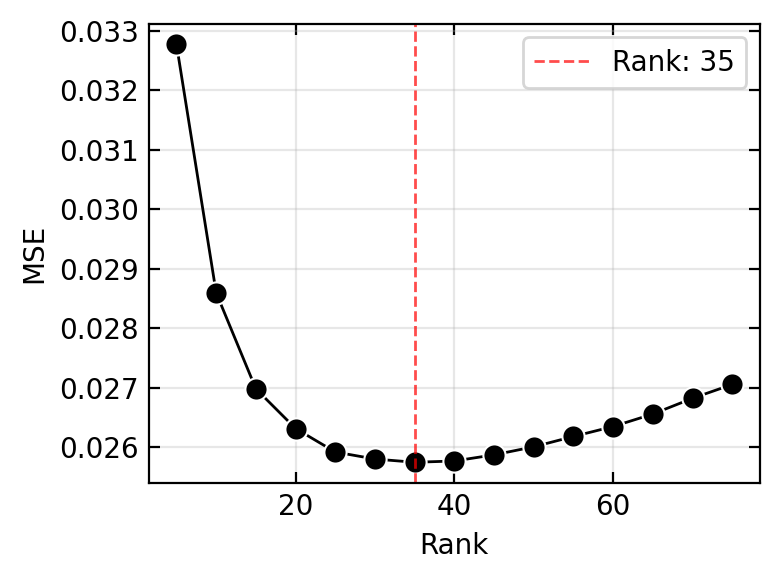

In [60]:
fig, ax = plt.subplots(figsize=(4,3), dpi=200)

sns.lineplot(
    data=spose_dimension_df, 
    x="param_rank", 
    y="mean_test_score",
    color="black",
    marker="o",
    linewidth=1,
    markersize=8,
    ax=ax,
)

best_rank = spose_dimension_df.loc[spose_dimension_df["mean_test_score"].idxmin(), "param_rank"]
best_score = spose_dimension_df["mean_test_score"].min()

ax.axvline(x=best_rank, color="red", linestyle="--", alpha=0.7, linewidth=1, label=f"Rank: {best_rank}")

ax.set_xlabel("Rank")
ax.set_ylabel("Mean test score")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.tick_params(
    direction="in",
    top=True,
    right=True,
    which="both",
    labelsize=10,
    length=4,
)
ax.set_xlabel("Rank")
ax.set_ylabel("MSE")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
